In [1]:
from shared_notebook_utils import *
from analysis_algorithms import *
import essentia
import essentia.standard as estd
import random
dataset = Dataset('toy_dataset')
%matplotlib inline

# This notebook contains excerpts from the article: Font, F., & Serra, X. (2016). Tempo Estimation for Music Loops and a Simple Confidence Measure. In Proceedings of the Int. Conf. on Music Information Retrieval (ISMIR).
# License: CC-BY-4.0

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Confidence measure


Assuming that we obtain a BPM estimate for a given audio signal, the confidence measure that we propose is based on comparing the duration of the whole audio signal with a multiple of the duration of a single beat according to the estimated BPM. If the actual duration of the signal is close to a multiple of the duration of a single beat, we hypothesise that the BPM estimation is reliable.
We consider the best BPM estimate of a tempo estimation algorithm to be its nearest integer value (see paper for more details).
Given the sample rate $SR$ of an audio signal and its estimated tempo $BPM^e$, we can estimate the duration (or length) of an individual beat in number of samples $l^b$ as
$$l^b = \frac{60 \cdot SR}{BPM^e}.$$ 

Then, potential durations for the audio signal can be computed as multiples of the individual beat duration, $L[n] = n \cdot l^b$, where $n \geq 1, n \in \mathbb{Z}$.
In our computation, we restrict $n$ to the range $1 \le n \le 128$.
This is decided so that the range can include loops that last from only 1 beat to 128 beats, which would correspond to a maximum of 32 bars in 4/4 meter. 
In practice, what we need here is a number big enough such that we wont find loops longer than it.
Given $L$, what we need to see at this point is if any of its elements closely matches the actual length of the original audio signal. 
To do that, we take the actual length of the audio signal $l^a$ (in number of samples), compare it with all elements of $L$ and keep the minimum difference found:

$$ \Delta l = \min\{|L[n]-l^a|:n\le 128\}. $$

A value of $\Delta l$ near 0 means that there is a close match between one of the potential lengths and the actual length of the audio signal. 
Having computed $\Delta l$, we finally define our confidence measure as 

$$ 
confidence = \begin{cases} 
	0 & \text{if } \Delta l > \lambda \\
    1 - \frac{\Delta l}{\lambda} & \text{otherwise}\\
\end{cases},
$$

where $\lambda$ is a parameter set to half the duration of a single beat ($\lambda = 0.5 \cdot l^b$). In this way, if $l^a$ exactly matches one of the multiples of $l^b$, the confidence will be 1. If $\Delta l$ is as long as half the duration between beats, the confidence will be 0 (see top of the figure below).

The reasoning behind this simple confidence measure is that it is very unlikely that, only by chance, an audio signal has a duration which closely matches a multiple of the beat duration for a given estimated BPM. This means that we assume that there is a relation between the duration of the signal and its BPM, and therefore our proposed confidence will fail if the audio signal contains silence (either at the beginning or at the end) which is not part of the loop itself (i.e.,~ the loop is not *accurately cut*).
To account for this potential problem, we estimate the duration that the audio signal would have if we removed silence at the beginning, at the end, or both at the beginning and at the end.
We take the envelope of the original audio and consider the effective starting point of the loop as being the point in time $t_s$ where the envelope amplitude raises above 5\% of the maximum.
Similarly, we consider the effective end $t_e$ at the *last point* where the envelope goes below the 5\% of the maximum amplitude (or at the end of the audio signal if envelope is still above 5\%). 
Taking $t_s$, $t_e$, and $l^a$ (the original signal length), we can then compute three alternative estimates for the duration of the loop ($l_0^{a}$, $l_1^{a}$ and $l_2^{a}$) by *i)* disregarding silence at the beginning ($l_0^{a} = l^a - t_s$), *ii)* disregarding silence a the end ($l_1^{a} = t_e$), and *iii)* disregarding silence both at the beginning and at the end ($l_2^{a} = t_e - t_s$).
Then, we repeat the previously described confidence computation with the three extra duration estimates $l_0^{a}$, $l_1^{a}$ and $l_2^{a}$. 
Note that these will produce meaningful results in cases where the original loop contains silence which is not relevant from a musical point of view, but they will not result in meaningful confidence values if the loop contains silence at the beginning or at the end which is in fact part of the loop (i.e.,~which is needed for it seamless repetition).
Our final confidence value is taken as the maximum confidence obtained when using any of $l^{a}$, $l_0^{a}$, $l_1^{a}$ and $l_2^{a}$ estimated signal durations (see bottom of figure below).

Because the confidence measure that we propose only relies on a BPM estimate and the duration of the audio signal, it can be used in combination with any existing tempo estimation algorithm. Also, it is computationally cheap to compute as the most complex operation it requires is the envelope computation. However, this confidence measure should not be applied to content other than music loops as it only produces meaningful results under the assumption that tempo is completely steady across the whole signal.





Selected sound id: 63470
------------------------



Selected sound ground truth bpm: 140.00
Selected sound estimated bpm: 119.00
  Confidence: 0.59

Selected sound id: 43209
------------------------



Selected sound ground truth bpm: 91.00
Selected sound estimated bpm: 91.00
  Confidence for "Standard duration": 0.40
  Confidence for "Removed silence beginning": 0.70
  Confidence for "Removed silence end": 0.66
  Confidence for "Removed slience beginning and end": 0.97


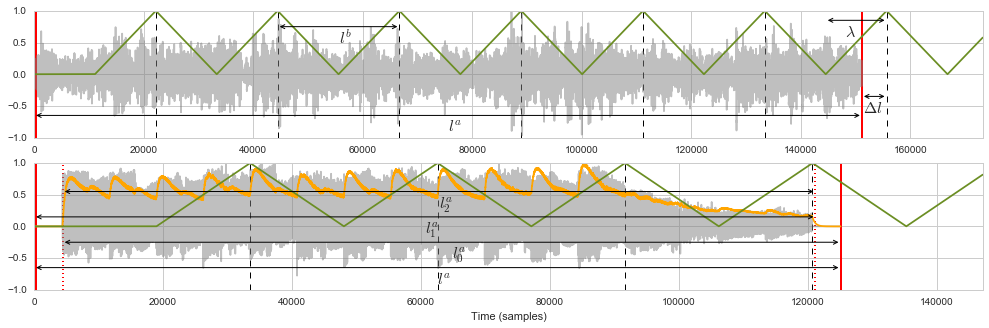


**Figure 1**: Visualisation of confidence computation output according to BPM estimation and signal duration (green curves). The top figure shows a loop whose annotated tempo is 140 BPM but the predicted tempo is 119 BPM.
The duration of the signal $l^a$ does not closely match any multiple of $l^b$ (dashed vertical lines), and the output confidence is 0.59 (i.e.,~$1 - \Delta l / \lambda$).
The figure at the bottom shows a loop that contains silence at the beginning and at the end, and for which tempo has been correctly estimated as being 91 BPM.
The yellow curve represents its envelope and the vertical dashed red lines the estimated effective start and end points.
Note that $l_2^a$ closely matches a multiple of $l^b$, resulting in a confidence of 0.97. The output confidence computed with $l^{a}$, $l_0^{a}$ and $l_1^{a}$ produces lower values.


In [2]:
# The following code exemplifies the computation of the confidence measure for two different sound examples 
# and generates Figure 1 of the paper.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 5))
sample_rate=44100


# Top of the figure: loop for which BPM estimation fails
########################################################

# Select and load a sound
# Sound: "edison_140d.wav" by NoiseCollector, got from Freesound at http://www.freesound.org/people/NoiseCollector/sounds/63470/
# License: CC-BY-3.0
selected_sound = dataset.data['63470']
print title('Selected sound id: %s' % selected_sound['id'])
sound_file_path = os.path.join(dataset.dataset_path, selected_sound['wav_sound_path'])
selected_sound['file_path'] = sound_file_path
audio_1 = load_audio_file(file_path=sound_file_path, sample_rate=sample_rate)
bpm_1 = algorithm_rhythm_percival14(selected_sound)['Percival14']['bpm']
bpm_1 = int(round(bpm_1))
IPython.display.display(IPython.display.Audio(sound_file_path), embed=True)
print 'Selected sound ground truth bpm: %.2f' % selected_sound['annotations']['bpm']
print 'Selected sound estimated bpm: %.2f' % bpm_1

# Compute confidence based on "standard" audio signal duration
beat_duration = (60.0 * sample_rate)/bpm_1
L = [beat_duration * n for n in range(1, 128)]
thr_lambda = 0.5 * beat_duration
la = audio_1.shape[0]
delta_l = min([abs(l - la) for l in L])
if delta_l > thr_lambda:
    confidence_la = 0.0
else:
    confidence_la = (1.0 - float(delta_l) / thr_lambda)
print '  Confidence: %.2f' % confidence_la

# Plot
ax1.plot(normalize2(audio_1), color="gray", alpha=0.5)
ax1.vlines(L, -1, 1, color='black', linewidth=1, linestyle="--")
ax1.vlines([350, la], -1, 1, color='red', linewidth=2)
annotate_point_pair(ax1, r'$l^a$', (0, -0.65), (la, -0.65), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax1, r'$l^b$', (L[1], 0.75), (L[2], 0.75), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax1, r'$\Delta l$', (la, -0.35), (la + delta_l, -0.35), xycoords='data', text_offset=16, textx_offset=-2000, text_size=16)
annotate_point_pair(ax1, r'$\lambda$', (la + delta_l - thr_lambda, 0.85), (la + delta_l, 0.85), xycoords='data', text_offset=16, textx_offset=-2000, text_size=16)
confidence_output = list()
for i in range(0, la*2):
    delta = min([abs(l - i) for l in L])
    if delta > thr_lambda:
        confidence_output.append(0.0)
    else:
        value = 1.0 - float(delta) / thr_lambda
        confidence_output.append(value)
ax1.plot(confidence_output, color=COLORS[2])
ax1.set_xlim((0, la + 44100/2))
ax1.set_ylim((-1, 1))
#ax1.set_xlabel('Time (samples)')


# Bottom of the figure: loop for which BPM estimation works but that has silence at the beggining
#################################################################################################

# Select and load sound and add 100 ms silence at the beginning and at the end
# Sound: "91Apat99999.wav" by NoiseCollector, got from Freesound at http://www.freesound.org/people/NoiseCollector/sounds/43209/
# License: CC-BY-3.0
selected_sound = dataset.data['43209']
print title('Selected sound id: %s' % selected_sound['id'])
sound_file_path = os.path.join(dataset.dataset_path, selected_sound['wav_sound_path'])
selected_sound['file_path'] = sound_file_path
audio_1 = load_audio_file(file_path=sound_file_path, sample_rate=sample_rate)
n_samples_silence = 4410
audio_2 = np.concatenate((np.zeros(n_samples_silence), audio_1, np.zeros(n_samples_silence)))
bpm_2 = algorithm_rhythm_percival14(selected_sound)['Percival14']['bpm']
bpm_2 = int(round(bpm_2))
IPython.display.display(IPython.display.Audio(sound_file_path), embed=True)
print 'Selected sound ground truth bpm: %.2f' % selected_sound['annotations']['bpm']
print 'Selected sound estimated bpm: %.2f' % bpm_2

# Compute confidence based on different durations
beat_duration = (60.0 * sample_rate)/bpm_2
L = [beat_duration * n for n in range(1, 128)]  # From 1 beat to 32 beats (would be 32 bars in 4/4)
thr_lambda = 0.5 * beat_duration
z = 0.05  # Percentage of the envelope amplitude that we use to compute start and end of signal
env = estd.Envelope(attackTime=10, releaseTime=10)
envelope = env(essentia.array(audio_2))
env_threshold = envelope.max() * z
envelope_above_threshold = np.where(envelope >= env_threshold)
start_effective_duration = envelope_above_threshold[0][0]
end_effective_duration = envelope_above_threshold[0][-1]
la = audio_2.shape[0]
durations_to_check = [
    ('Standard duration', la),
    ('Removed silence beginning', la - start_effective_duration),
    ('Removed silence end', end_effective_duration),
    ('Removed slience beginning and end', end_effective_duration - start_effective_duration)
]
for name, duration in durations_to_check:
    delta_l = min([abs(l - duration) for l in L])
    if delta_l > thr_lambda:
        confidence = 0.0
    else:
        confidence = (1.0 - float(delta_l) / thr_lambda)
    print '  Confidence for "%s": %.2f' % (name, confidence)

# Plot
ax2.plot(normalize2(audio_2), color="gray", alpha=0.5)
ax2.plot(normalize2(envelope), color=COLORS[1])
ax2.vlines([l + start_effective_duration for l in L], -1, 1, color='black', linewidth=1, linestyle="--")
ax2.vlines([start_effective_duration, end_effective_duration], -1, 1, color='red', linewidth=2, linestyle=":")
ax2.vlines([350, la], -1, 1, color='red', linewidth=2)
annotate_point_pair(ax2, r'$l^a$', (0, -0.65), (la, -0.65), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_0^a$', (start_effective_duration, -0.25), (la, -0.25), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_1^a$', (0, 0.15), (end_effective_duration, 0.15), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_2^a$', (start_effective_duration, 0.55), (end_effective_duration, 0.55), xycoords='data', text_offset=16, text_size=16)
confidence_output = list()
for i in range(0, la*2):
    delta = min([abs(l - i) for l in L])
    if delta > thr_lambda:
        confidence_output.append(0.0)
    else:
        value = 1.0 - float(delta) / thr_lambda
        confidence_output.append(value)
confidence_output = list(np.zeros(start_effective_duration)) + confidence_output
ax2.plot(confidence_output, color=COLORS[2])
ax2.set_xlim((0, la + 44100/2))
ax2.set_ylim((-1, 1))
ax2.set_xlabel('Time (samples)')

plt.show()
figure_caption = """
**Figure 1**: Visualisation of confidence computation output according to BPM estimation and signal duration (green curves). The top figure shows a loop whose annotated tempo is 140 BPM but the predicted tempo is 119 BPM.
The duration of the signal $l^a$ does not closely match any multiple of $l^b$ (dashed vertical lines), and the output confidence is 0.59 (i.e.,~$1 - \Delta l / \lambda$).
The figure at the bottom shows a loop that contains silence at the beginning and at the end, and for which tempo has been correctly estimated as being 91 BPM.
The yellow curve represents its envelope and the vertical dashed red lines the estimated effective start and end points.
Note that $l_2^a$ closely matches a multiple of $l^b$, resulting in a confidence of 0.97. The output confidence computed with $l^{a}$, $l_0^{a}$ and $l_1^{a}$ produces lower values.
"""
IPython.display.display(IPython.display.Markdown(figure_caption))